In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prophet libs
import prophet

## 1. Loading data

In [76]:
# Fixing csv file
with open("data/air_quality_sensor_data.csv", "r") as f:
    text = ''.join([i for i in f]).replace(";", ",")

with open("data/air_quality_sensor_data.csv", "w") as f:
    f.writelines(text)

In [77]:
# Loading data
df = pd.read_csv("data/air_quality_sensor_data.csv")
print(df.shape)
df.head()

(360, 4)


,Timestamp,PM1,PM10,PM25
0,2021-11-11 14:04:03,10,36.016907,29.994762
1,2021-11-11 16:04:03,10,39.262622,29.965451
2,2021-11-11 18:04:03,10,40.017659,29.963461
3,2021-11-11 20:04:03,10,43.428453,29.999926
4,2021-11-11 22:04:03,10,44.946480,29.992089


In [78]:
# Removing unnecessary data (Only predicting PM10)
df = df.drop(["PM1", "PM25"], axis=1)
# Renaming Timestamp column ds and PM10 to y 
df.rename(columns={'Timestamp':'ds'}, inplace=True)
df.rename(columns={'PM10':'y'}, inplace=True)

print(f"Shape: {df.shape}")
print(f"Data Types: {df.shape}")
df.head()

Shape: (360, 2)
Data Types: (360, 2)


,ds,y
0,2021-11-11 14:04:03,36.016907
1,2021-11-11 16:04:03,39.262622
2,2021-11-11 18:04:03,40.017659
3,2021-11-11 20:04:03,43.428453
4,2021-11-11 22:04:03,44.946480


In [79]:
df.describe()

,y
count,360.000000
mean,45.060716
std,9.946582
min,31.062247
25%,36.863576
50%,41.113733
75%,56.199117
max,60.000000


<AxesSubplot:>

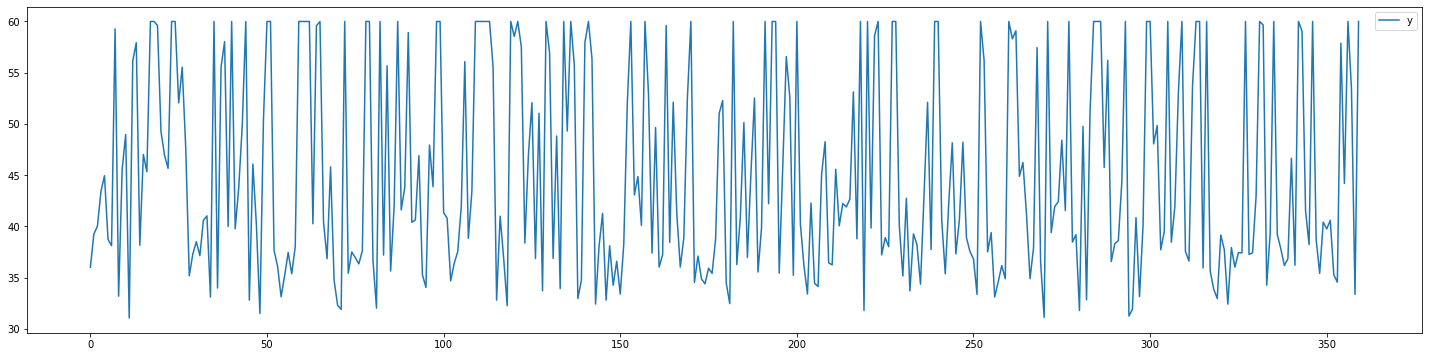

In [80]:
# Plotting data
plt.rcParams['figure.figsize'] = [25, 6]
df.plot()

## 2. Prophet Model

#### 2.1 Training Model

In [81]:
m = prophet.Prophet()
pro_model = m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -10.191


/home/irayb/miniconda3/envs/aq_pred/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       478.063   1.09199e-06       91.5453      0.2559      0.2559      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       478.064   2.29208e-07       102.837   2.379e-09       0.001      268  LS failed, Hessian reset 
     182       478.064   5.10593e-09       96.2179      0.1827      0.1827      276   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
